# Analysing the activation distributions of different datasets

In [30]:
import torch

In [31]:
import probe_gen.probes as probes

layer = 20

activations_tensor_on, attention_mask_on, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", layer, verbose=True)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_off, attention_mask_off, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", layer, verbose=True)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels


loaded activations
calculated attention mask
loaded labels
loaded activations
calculated attention mask


In [32]:
def project_onto_line_batch(X, A, B):
    """
    Project a batch of vectors X onto the line connecting A and B.
    
    Args:
        X: torch.Tensor of shape [n, d] - batch of vectors to project
        A: torch.Tensor of shape [d] - start point of line
        B: torch.Tensor of shape [d] - end point of line
    
    Returns:
        distances: torch.Tensor of shape [n] - absolute distances along line from A
                  distances[i]=0 means X[i]'s projection is at A
                  distances[i]>0 means X[i]'s projection is in direction of B
                  distances[i]<0 means X[i]'s projection is in opposite direction from B
                  distances[i]=||B-A|| means X[i]'s projection is at B
    """
    # Vector from A to B - shape [d]
    AB = B - A
    
    # Vector from A to each X - shape [n, d]
    AX = X - A.unsqueeze(0)  # A.unsqueeze(0) broadcasts A to shape [1, d]
    
    # Project each AX onto AB using batched dot product
    # AX @ AB gives us the dot product for each vector in the batch
    # AB @ AB gives us ||AB||^2
    numerator = torch.sum(AX * AB.unsqueeze(0), dim=1)  # shape [n]
    denominator = torch.dot(AB, AB)  # scalar
    
    # Get relative parameters for each vector
    t_batch = numerator / denominator  # shape [n]
    
    # Convert to absolute distances by multiplying by length of AB
    AB_length = torch.norm(AB)
    distances = t_batch * AB_length
    
    return distances

In [ ]:
import matplotlib.pyplot as plt

def plot_activations_mean_line_projections_distributions(activations_1, activations_2, labels, layer):
    mean_1 = activations_1.mean(dim=0)
    mean_2 = activations_2.mean(dim=0)

    distances_1 = project_onto_line_batch(activations_1, mean_1, mean_2)
    distances_2 = project_onto_line_batch(activations_2, mean_1, mean_2)

    mean_distance_1 = project_onto_line_batch(mean_1.unsqueeze(0), mean_1, mean_2)[0]
    mean_distance_2 = project_onto_line_batch(mean_2.unsqueeze(0), mean_1, mean_2)[0]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 1, 1)
    plt.hist(distances_1, alpha=0.5, label=labels[0], bins=40)
    plt.hist(distances_2, alpha=0.5, label=labels[1], bins=40)
    plt.axvline(x = mean_distance_1, color = 'blue', linestyle='dashed', label = f'{labels[0]} mean')
    plt.axvline(x = mean_distance_2, color = 'orange', linestyle='dashed', label = f'{labels[1]} mean')
    plt.xlabel(f'Distance from mean of {labels[0]}')
    plt.ylabel('Count')
    plt.legend()
    plt.title(f'Activation projections onto mean line (layer {layer})')

    plt.tight_layout()
    plt.show()


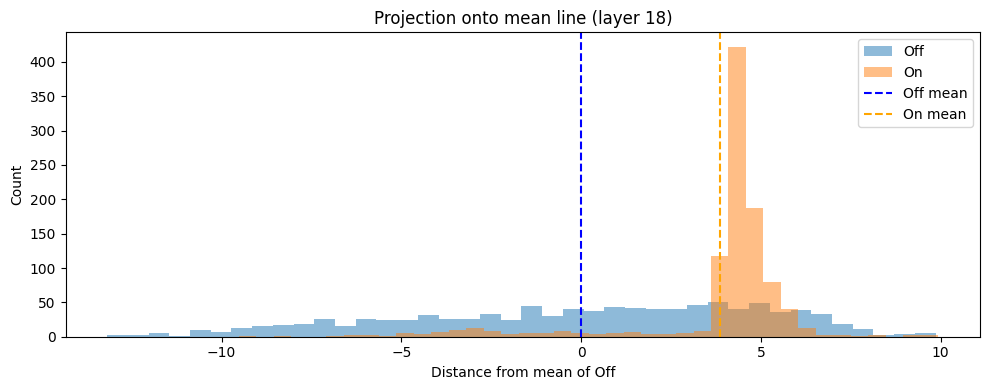

In [40]:
import probe_gen.probes as probes

layers = [18]

for layer in layers:

    activations_tensor_on, attention_mask_on, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", layer, verbose=False)
    activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

    activations_tensor_off, attention_mask_off, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", layer, verbose=False)
    activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

    #plot_activations_mean_line_projections_distributions(activations_tensor_on, activations_tensor_off, ['On', 'Off'], layer)
    plot_activations_mean_line_projections_distributions(activations_tensor_off, activations_tensor_on, ['Off', 'On'], layer)

In [33]:
mean_on = activations_tensor_on.mean(dim=0)
mean_off = activations_tensor_off.mean(dim=0)

In [34]:
distances_on = project_onto_line_batch(activations_tensor_on, mean_on, mean_off)
distances_off = project_onto_line_batch(activations_tensor_off, mean_on, mean_off)

In [35]:
mean_on_distance = project_onto_line_batch(mean_on.unsqueeze(0), mean_on, mean_off)
mean_off_distance = project_onto_line_batch(mean_off.unsqueeze(0), mean_on, mean_off)
print(mean_on_distance)
print(mean_off_distance)

tensor([0.])
tensor([4.4338])


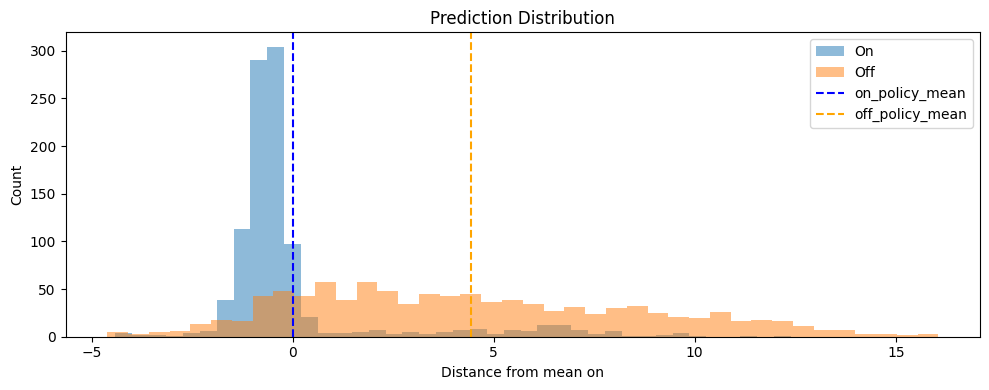

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)
plt.hist(distances_on, alpha=0.5, label='On', bins=40)
plt.hist(distances_off, alpha=0.5, label='Off', bins=40)
plt.axvline(x = mean_on_distance, color = 'blue', linestyle='dashed', label = 'on_policy_mean')
plt.axvline(x = mean_off_distance, color = 'orange', linestyle='dashed', label = 'off_policy_mean')
plt.xlabel('Distance from mean on')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

# PCA

In [48]:
import probe_gen.probes as probes

layer = 26

activations_tensor_on, attention_mask_on, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", layer, verbose=True)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_off, attention_mask_off, _ = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", layer, verbose=True)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels


loaded activations
calculated attention mask
loaded labels
loaded activations
calculated attention mask


In [49]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def visualize_datasets_pca(dataset1, dataset2, n_components=2, dataset1_name="Dataset 1", dataset2_name="Dataset 2", figsize=(10, 8)):
    """
    Perform PCA on combined datasets and visualize with different colors for each dataset.
    
    Args:
        dataset1: torch.Tensor of shape [n1, d] - first dataset
        dataset2: torch.Tensor of shape [n2, d] - second dataset  
        n_components: int - number of PCA components (2 for 2D plot, 3 for 3D plot)
        dataset1_name: str - label for first dataset
        dataset2_name: str - label for second dataset
        figsize: tuple - figure size for matplotlib
    
    Returns:
        pca: fitted PCA object
        transformed_data: numpy array of shape [n1+n2, n_components] - PCA transformed data
        labels: numpy array indicating which dataset each point belongs to
    """
    
    # Convert to numpy if needed and combine datasets
    if isinstance(dataset1, torch.Tensor):
        dataset1 = dataset1.detach().cpu().numpy()
    if isinstance(dataset2, torch.Tensor):
        dataset2 = dataset2.detach().cpu().numpy()
    
    # Combine the datasets
    combined_data = np.vstack([dataset1, dataset2])
    n1, n2 = len(dataset1), len(dataset2)
    
    # Create labels (0 for dataset1, 1 for dataset2)
    labels = np.concatenate([np.zeros(n1), np.ones(n2)])
    
    # Perform PCA on combined data
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(combined_data)
    
    # Split back into separate datasets for plotting
    dataset1_pca = transformed_data[:n1]
    dataset2_pca = transformed_data[n1:]
    
    # Create the plot
    if n_components == 2:
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot both datasets with different colors
        scatter1 = ax.scatter(dataset1_pca[:, 0], dataset1_pca[:, 1], 
                             alpha=0.7, label=dataset1_name, s=50)
        scatter2 = ax.scatter(dataset2_pca[:, 0], dataset2_pca[:, 1], 
                             alpha=0.7, label=dataset2_name, s=50)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax.set_title('PCA Visualization of Two Datasets')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
    elif n_components == 3:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot both datasets with different colors
        ax.scatter(dataset1_pca[:, 0], dataset1_pca[:, 1], dataset1_pca[:, 2],
                  alpha=0.7, label=dataset1_name, s=50)
        ax.scatter(dataset2_pca[:, 0], dataset2_pca[:, 1], dataset2_pca[:, 2],
                  alpha=0.7, label=dataset2_name, s=50)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
        ax.set_title('3D PCA Visualization of Two Datasets')
        ax.legend()
        
    else:
        raise ValueError("n_components must be 2 or 3 for visualization")
    
    plt.tight_layout()
    plt.show()
    
    # Print some useful information
    print(f"Dataset 1 shape: {dataset1.shape}")
    print(f"Dataset 2 shape: {dataset2.shape}")
    print(f"Combined dataset shape: {combined_data.shape}")
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.1%}")
    
    return pca, transformed_data, labels

def plot_pca_components_analysis(pca, max_components=10):
    """
    Plot explained variance ratio for different numbers of components.
    """
    n_components = min(max_components, len(pca.explained_variance_ratio_))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Individual explained variance
    ax1.bar(range(1, n_components + 1), pca.explained_variance_ratio_[:n_components])
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance by Component')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_[:n_components])
    ax2.plot(range(1, n_components + 1), cumulative_variance, 'bo-')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('Cumulative Explained Variance')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()



Performing PCA visualization...


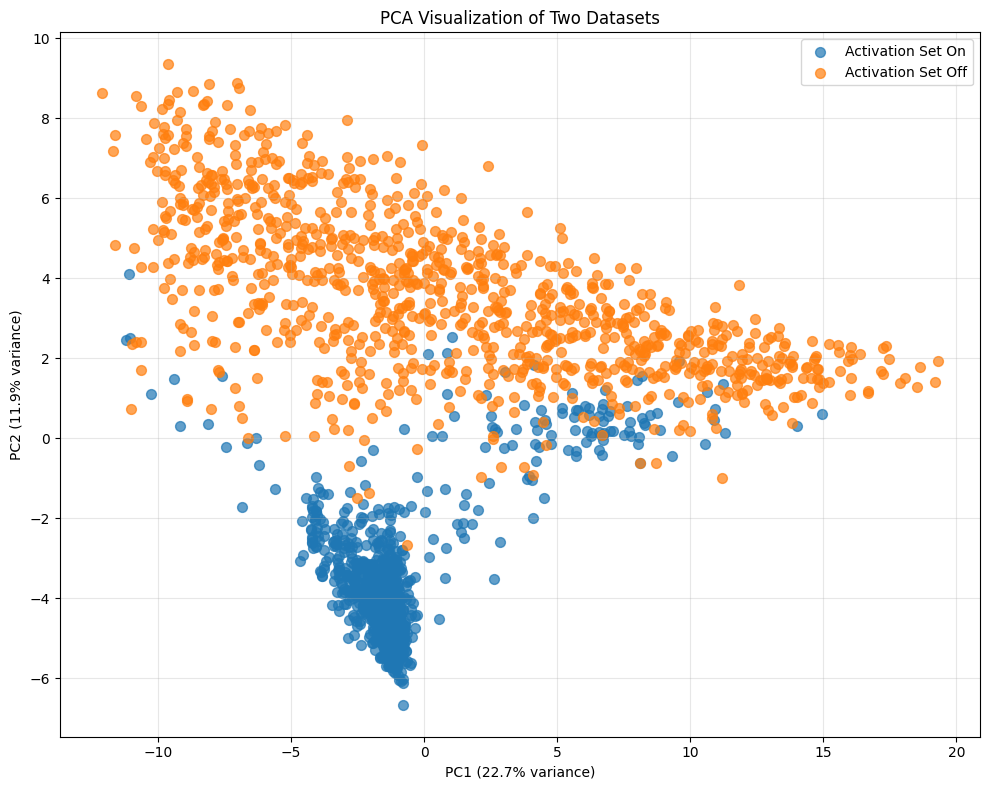

Dataset 1 shape: (1000, 3072)
Dataset 2 shape: (1000, 3072)
Combined dataset shape: (2000, 3072)
PCA explained variance ratio: [0.22709276 0.1186366 ]
Total explained variance: 34.6%

3D Visualization:


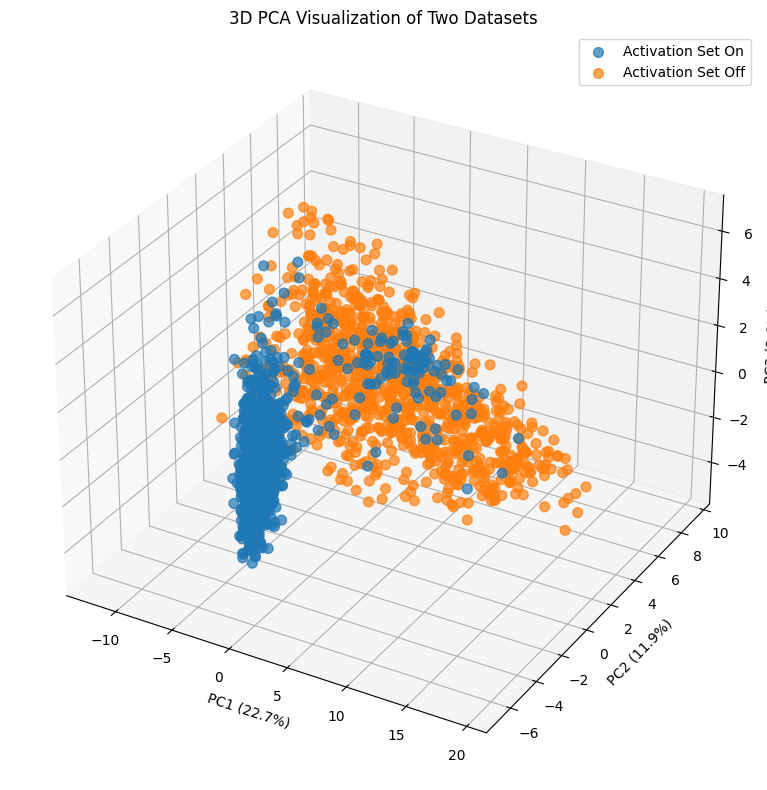

Dataset 1 shape: (1000, 3072)
Dataset 2 shape: (1000, 3072)
Combined dataset shape: (2000, 3072)
PCA explained variance ratio: [0.22709273 0.1186366  0.02576161]
Total explained variance: 37.1%

PCA Components Analysis:


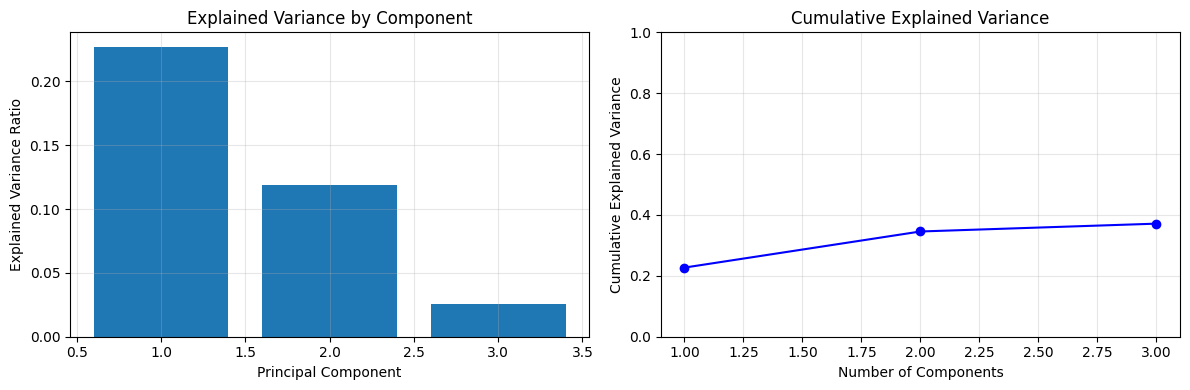

In [ ]:

# Generate example datasets
torch.manual_seed(42)
np.random.seed(42)

print("Performing PCA visualization...")

# 2D visualization
pca_2d, transformed_2d, labels = visualize_datasets_pca(
    activations_tensor_on, activations_tensor_off, 
    n_components=2,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off"
)

# 3D visualization
print("\n" + "="*50)
print("3D Visualization:")
pca_3d, transformed_3d, labels = visualize_datasets_pca(
    activations_tensor_on, activations_tensor_off, 
    n_components=3,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off"
)

# Component analysis
print("\n" + "="*50)
print("PCA Components Analysis:")
plot_pca_components_analysis(pca_3d, max_components=10)